In [11]:
# MCSB Bootcamp NPC Simulator
# Yueqi Ren yueqir@uci.edu

# Initially from:
# Jun Allard jun.allard@uci.edu

# Simulate a transcription factor diffusing inside the cytoplasm, searching for a nuclear pore complex

# To do parallel computing, please open Julia REJL (Julia's command line) and enter:

#> using IJulia
#> IJulia.installkernel("Julia 8 Threads", env=Dict(
#>     "JULIA_NUM_THREADS" => "8",
#> ))

# with "JULIA_NUM_THREADS" => "8" being "8" for a quad-core and "4" for a dual-core computer

# Then, go to the Jupyter notebook toolbar, select Kernel --> "Julia 8 Threads 1.5.1" (or similar name)

Threads.nthreads() # nthreads should now be 8 (or 4, depending on settings)

8

In [2]:
# Install relevant packages
using Pkg
Pkg.add("PyPlot")
Pkg.add("Random")
using Random

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


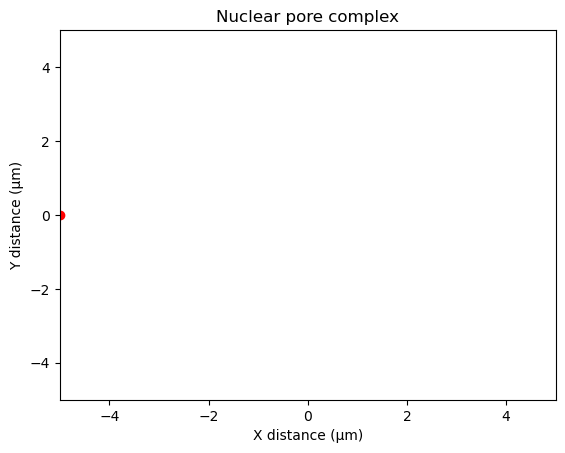

PyObject Text(24.000000000000007, 0.5, 'Y distance (µm)')

In [15]:
# Numerical parameters
NSample = 2000 # number of samples
L = 10 # microns
NPCLocation = [-L/2 0]
# Set up figure
using PyPlot
Plots.pyplot()
p = PyPlot.scatter(NPCLocation[1], NPCLocation[2],marker="o",color="r")
PyPlot.xlim([-L/2, L/2])
PyPlot.ylim([-L/2, L/2])
PyPlot.title("Nuclear pore complex")
PyPlot.xlabel("X distance (µm)")
PyPlot.ylabel("Y distance (µm)")

In [8]:
# Single thread
function NPCS_simulate(NSample)
    # Model parameters
    D = 10 # microns^2/second
    L = 10 # microns
    NPCSize = 0.1 # microns
    NPCLocation = [-L/2 0]
    dt = 0.001 # s
    alpha = sqrt(2*D*dt)
    ntmax = 1e6
    tCapture = zeros(NSample, 1)
    
    for iSample in 1:NSample
        # intial condition
        x = [L/2 0]
        t = 0
        for nt in 1:ntmax
            # dynamics
            x += alpha*randn(1,2)
            # boundaries
            if x[1] > L/2
                x[1] = L/2
            elseif x[1] < -L/2
                x[1] = -L/2
            end
            if x[2] > L/2
                x[2] = L/2
            elseif x[2] < -L/2
                x[2] = -L/2
            end
            # test for NPC capture
            if ((x[1] - NPCLocation[1])^2 + (x[2] - NPCLocation[2])^2) < NPCSize^2
                tCapture[iSample] = t
                break
            end
            t = t+dt
        end # finished loop through time
        end # finished loop through samples
    return tCapture
end

# @time tCapture = NPCS_simulate(NSample) # quad-core Macbook Pro, Julia: 7 seconds, Matlab: 14 seconds

NPCS_simulate (generic function with 1 method)

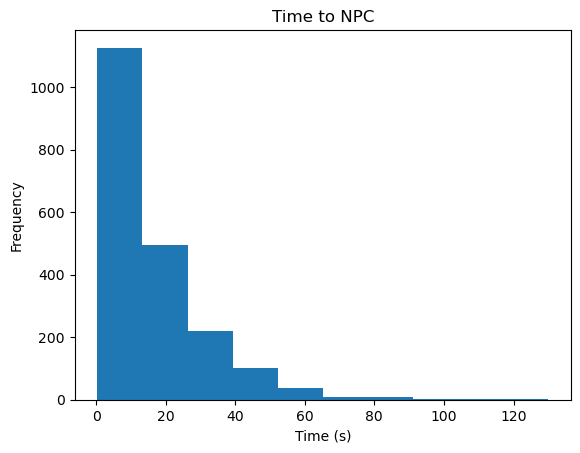

  3.664267 seconds (98.06 M allocations: 8.732 GiB, 39.28% gc time)


In [10]:
# Multithreading
function NPCS_simulate_parallel(NSample)
    # Model parameters
    D = 10 # microns^2/second
    L = 10 # microns
    NPCSize = 0.1 # microns
    NPCLocation = [-L/2 0]
    dt = 0.001 # s
    alpha = sqrt(2*D*dt)
    ntmax = 1e6
    tCapture = zeros(NSample, 1)
    
    Threads.@threads for iSample = 1:NSample
        # intial condition
        x = [L/2 0]
        t = 0
        for nt in 1:ntmax
            # dynamics
            x += alpha*randn(1,2)
            # boundaries
            if x[1] > L/2
                x[1] = L/2
            elseif x[1] < -L/2
                x[1] = -L/2
            end
            if x[2] > L/2
                x[2] = L/2
            elseif x[2] < -L/2
                x[2] = -L/2
            end
            # test for NPC capture
            if ((x[1] - NPCLocation[1])^2 + (x[2] - NPCLocation[2])^2) < NPCSize^2
                tCapture[iSample] = t
                break
            end
            t = t+dt
        end # finished loop through time
    end # finished loop through samples
    return tCapture
end

NSample = 2000 # number of samples
@time tCapture = NPCS_simulate_parallel(NSample)

# Analyze results
PyPlot.hist(tCapture);
PyPlot.title("Time to NPC");
PyPlot.xlabel("Time (s)");
PyPlot.ylabel("Frequency");